In [1]:
!pip install torch torchvision torchaudio
!pip install diffusers[torch] transformers accelerate datasets safetensors
!pip install open_clip_torch
!pip install pillow tqdm


Defaulting to user installation because normal site-packages is not writeable
    torch (>=1.9.*)
           ~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
    torch (>=1.9.*)
           ~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
    torch (>=1.9.*)
           ~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
    torch (>=1.9.*)
           ~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torchvision
from torch.utils.data import DataLoader
from PIL import Image
import os

# Directory to save images
os.makedirs("data/cifar10/images", exist_ok=True)

# Load CIFAR-10 (no transform needed!)
cifar10 = torchvision.datasets.CIFAR10(root="data/cifar10", download=True)

# Save all images as PNG (they're already PIL.Image.Image)
for idx, (img, _) in enumerate(cifar10):
    img.save(f"data/cifar10/images/{idx:05d}.png")


Files already downloaded and verified


In [3]:
import requests, zipfile, io
import os

# Download the DIV2K validation set (high-res)
url = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip"
output_dir = "data/div2k/images"
os.makedirs(output_dir, exist_ok=True)

response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(output_dir)


In [5]:
from open_clip import create_model_and_transforms, get_tokenizer
import torch
from PIL import Image
import os
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load OpenCLIP model
model, _, preprocess = create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model = model.to(device).eval()
tokenizer = get_tokenizer('ViT-B-32')

def get_caption(image_path):
    image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    with torch.no_grad():
        image_features = model.encode_image(image)
    # Simplified placeholder caption (can replace with nearest-neighbor text embedding search)
    return "a photo of something"

# Caption all CIFAR-10 images
image_dir = "data/cifar10/images"
caption_file = open("data/cifar10/captions.txt", "w")

for filename in tqdm(sorted(os.listdir(image_dir))):
    image_path = os.path.join(image_dir, filename)
    caption = get_caption(image_path)
    caption_file.write(f"{filename}\t{caption}\n")

caption_file.close()


100%|██████████| 50000/50000 [04:51<00:00, 171.59it/s]


In [6]:
!pip install datasets


Defaulting to user installation because normal site-packages is not writeable
    torch (>=1.9.*)
           ~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [7]:
from datasets import Dataset
from PIL import Image
import os

# Load image paths and captions
image_dir = "data/cifar10/images"
caption_path = "data/cifar10/captions.txt"

entries = []
with open(caption_path, "r") as f:
    for line in f:
        filename, caption = line.strip().split("\t")
        entries.append({
            "image_path": os.path.join(image_dir, filename),
            "text": caption
        })

# Create a Hugging Face Dataset
dataset = Dataset.from_list(entries)


In [8]:
from datasets import Features, Value, Image as HFImage

# Replace image_path with actual image data
dataset = dataset.cast_column("image_path", HFImage())
dataset = dataset.rename_column("image_path", "image")


In [9]:
print(dataset[0])


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32 at 0x15136D8A4C70>, 'text': 'a photo of something'}


In [10]:
from diffusers import AutoencoderKL
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load pretrained VAE from stable diffusion
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")
vae = vae.to(device).eval()


In [11]:
from torchvision import transforms

# Convert PIL to tensor
image = dataset[0]['image']
transform = transforms.Compose([
    transforms.Resize((512, 512)),  # VAE expects 512x512
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
x = transform(image).unsqueeze(0).to(device)  # (B,C,H,W)

with torch.no_grad():
    latents = vae.encode(x).latent_dist.sample() * 0.18215  # scale like SD


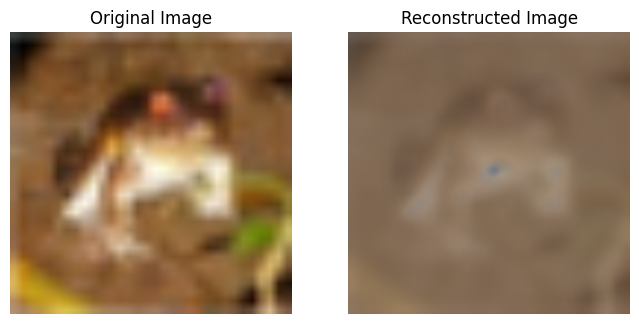

In [12]:
import matplotlib.pyplot as plt
from torchvision import transforms
import torch

# Load image and transform to tensor (VAE expects 512x512)
image = dataset[0]['image']

transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
input_tensor = transform(image).unsqueeze(0).to(device)

# Encode → Decode
with torch.no_grad():
    latents = vae.encode(input_tensor).latent_dist.sample() * 0.18215
    decoded = vae.decode(latents).sample

# Denormalize output
reconstructed = (decoded.squeeze(0).cpu() * 0.5 + 0.5).clamp(0, 1)

# Original image for comparison (also resize to 512)
original = transforms.Resize((512, 512))(image)

# Plot original vs reconstructed
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Reconstructed Image")
plt.imshow(reconstructed.permute(1, 2, 0))  # CHW → HWC
plt.axis("off")

plt.show()


In [13]:
from diffusers import UNet2DConditionModel

# Create a UNet (same as SD 1.x)
unet = UNet2DConditionModel(
    sample_size=64,
    in_channels=4,
    out_channels=4,
    layers_per_block=2,
    block_out_channels=(320, 640, 1280, 1280),
    down_block_types=(
        "CrossAttnDownBlock2D", "CrossAttnDownBlock2D",
        "CrossAttnDownBlock2D", "DownBlock2D"
    ),
    up_block_types=(
        "UpBlock2D", "CrossAttnUpBlock2D",
        "CrossAttnUpBlock2D", "CrossAttnUpBlock2D"
    ),
    cross_attention_dim=512   # MATCH this to text encoder
)

unet = unet.to(device)


In [14]:
from transformers import CLIPTextModel, CLIPTokenizer

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
text_encoder.eval()


CLIPTextModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), ep

In [15]:
# 1. Tokenize caption
text_input = tokenizer(
    dataset[0]["text"],
    padding="max_length",
    max_length=77,
    return_tensors="pt"
).to(device)

# 2. Encode text → text embeddings
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids)[0]  # (1, 77, 768)

# 3. Encode image to latent
image = dataset[0]['image']
x = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])(image).unsqueeze(0).to(device)

with torch.no_grad():
    latents = vae.encode(x).latent_dist.sample() * 0.18215

# 4. Add noise
noise = torch.randn_like(latents)
timesteps = torch.tensor([500], device=device).long()  # a random timestep
from diffusers import DDPMScheduler
scheduler = DDPMScheduler(num_train_timesteps=1000)
noisy_latents = scheduler.add_noise(latents, noise, timesteps)

# 5. Pass through UNet
unet.train()  # set to train mode
noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states=text_embeddings).sample
print("Predicted noise shape:", noise_pred.shape)


Predicted noise shape: torch.Size([1, 4, 64, 64])


In [16]:
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from tqdm import tqdm
import random

# Configs
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 1e-4
MAX_TRAIN_STEPS = 10000

# Prepare DataLoader
def collate_fn(batch):
    images = [item["image"] for item in batch]
    captions = [item["text"] for item in batch]
    return images, captions

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)


In [17]:
optimizer = optim.AdamW(unet.parameters(), lr=LEARNING_RATE)
mse_loss = nn.MSELoss()


In [18]:
unet.train()
vae.eval()
text_encoder.eval()

global_step = 0
scheduler.set_timesteps(1000)

for epoch in range(EPOCHS):
    for images, captions in tqdm(dataloader):
        if global_step >= MAX_TRAIN_STEPS:
            break

        # 1. Process images
        pixel_values = torch.stack([
            transforms.Compose([
                transforms.Resize((512, 512)),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
            ])(img) for img in images
        ]).to(device)

        with torch.no_grad():
            latents = vae.encode(pixel_values).latent_dist.sample() * 0.18215

        # 2. Sample noise
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()
        noisy_latents = scheduler.add_noise(latents, noise, timesteps)

        # 3. Process text
        text_inputs = tokenizer(captions, padding="max_length", truncation=True, max_length=77, return_tensors="pt").to(device)
        with torch.no_grad():
            encoder_hidden_states = text_encoder(text_inputs.input_ids)[0]

        # 4. Predict noise
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

        # 5. Compute loss
        loss = mse_loss(noise_pred, noise)

        # 6. Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if global_step % 100 == 0:
            print(f"Step {global_step} | Loss: {loss.item():.4f}")

        global_step += 1


  0%|          | 1/6250 [00:02<4:27:31,  2.57s/it]

Step 0 | Loss: 1.1334


  2%|▏         | 101/6250 [01:53<2:02:03,  1.19s/it]

Step 100 | Loss: 0.1458


  3%|▎         | 201/6250 [03:45<2:00:48,  1.20s/it]

Step 200 | Loss: 0.0483


  5%|▍         | 301/6250 [05:37<1:58:49,  1.20s/it]

Step 300 | Loss: 0.1054


  6%|▋         | 401/6250 [07:29<1:56:46,  1.20s/it]

Step 400 | Loss: 0.0246


  8%|▊         | 501/6250 [09:22<1:54:44,  1.20s/it]

Step 500 | Loss: 0.0349


 10%|▉         | 601/6250 [11:14<1:52:55,  1.20s/it]

Step 600 | Loss: 0.0329


 11%|█         | 701/6250 [13:06<1:50:56,  1.20s/it]

Step 700 | Loss: 0.0543


 13%|█▎        | 801/6250 [14:58<1:48:48,  1.20s/it]

Step 800 | Loss: 0.0391


 14%|█▍        | 901/6250 [16:51<1:46:54,  1.20s/it]

Step 900 | Loss: 0.0355


 16%|█▌        | 1001/6250 [18:43<1:44:48,  1.20s/it]

Step 1000 | Loss: 0.1019


 18%|█▊        | 1101/6250 [20:35<1:42:52,  1.20s/it]

Step 1100 | Loss: 0.0499


 19%|█▉        | 1201/6250 [22:28<1:40:53,  1.20s/it]

Step 1200 | Loss: 0.0274


 21%|██        | 1301/6250 [24:20<1:38:49,  1.20s/it]

Step 1300 | Loss: 0.0216


 22%|██▏       | 1401/6250 [26:12<1:36:47,  1.20s/it]

Step 1400 | Loss: 0.0586


 24%|██▍       | 1501/6250 [28:04<1:34:53,  1.20s/it]

Step 1500 | Loss: 0.1420


 26%|██▌       | 1601/6250 [29:57<1:32:53,  1.20s/it]

Step 1600 | Loss: 0.0068


 27%|██▋       | 1701/6250 [31:49<1:30:45,  1.20s/it]

Step 1700 | Loss: 0.0521


 29%|██▉       | 1801/6250 [33:41<1:28:51,  1.20s/it]

Step 1800 | Loss: 0.0193


 30%|███       | 1901/6250 [35:34<1:26:51,  1.20s/it]

Step 1900 | Loss: 0.1025


 32%|███▏      | 2001/6250 [37:26<1:24:48,  1.20s/it]

Step 2000 | Loss: 0.0388


 34%|███▎      | 2101/6250 [39:18<1:22:53,  1.20s/it]

Step 2100 | Loss: 0.0141


 35%|███▌      | 2201/6250 [41:11<1:20:52,  1.20s/it]

Step 2200 | Loss: 0.0664


 37%|███▋      | 2301/6250 [43:03<1:18:48,  1.20s/it]

Step 2300 | Loss: 0.0706


 38%|███▊      | 2401/6250 [44:55<1:16:57,  1.20s/it]

Step 2400 | Loss: 0.0882


 40%|████      | 2501/6250 [46:48<1:14:54,  1.20s/it]

Step 2500 | Loss: 0.0225


 42%|████▏     | 2601/6250 [48:40<1:13:00,  1.20s/it]

Step 2600 | Loss: 0.0066


 43%|████▎     | 2701/6250 [50:32<1:10:54,  1.20s/it]

Step 2700 | Loss: 0.0513


 45%|████▍     | 2801/6250 [52:24<1:08:58,  1.20s/it]

Step 2800 | Loss: 0.0269


 46%|████▋     | 2901/6250 [54:17<1:06:52,  1.20s/it]

Step 2900 | Loss: 0.0228


 48%|████▊     | 3001/6250 [56:09<1:04:50,  1.20s/it]

Step 3000 | Loss: 0.0181


 50%|████▉     | 3101/6250 [58:01<1:02:54,  1.20s/it]

Step 3100 | Loss: 0.1185


 51%|█████     | 3201/6250 [59:54<1:00:52,  1.20s/it]

Step 3200 | Loss: 0.0468


 53%|█████▎    | 3301/6250 [1:01:46<58:52,  1.20s/it]

Step 3300 | Loss: 0.0177


 54%|█████▍    | 3401/6250 [1:03:38<56:53,  1.20s/it]

Step 3400 | Loss: 0.0191


 56%|█████▌    | 3501/6250 [1:05:30<54:52,  1.20s/it]

Step 3500 | Loss: 0.0533


 58%|█████▊    | 3601/6250 [1:07:23<52:54,  1.20s/it]

Step 3600 | Loss: 0.0482


 59%|█████▉    | 3701/6250 [1:09:15<50:54,  1.20s/it]

Step 3700 | Loss: 0.0875


 61%|██████    | 3801/6250 [1:11:07<48:52,  1.20s/it]

Step 3800 | Loss: 0.0204


 62%|██████▏   | 3901/6250 [1:13:00<46:53,  1.20s/it]

Step 3900 | Loss: 0.0346


 64%|██████▍   | 4001/6250 [1:14:52<44:55,  1.20s/it]

Step 4000 | Loss: 0.0153


 66%|██████▌   | 4101/6250 [1:16:44<42:54,  1.20s/it]

Step 4100 | Loss: 0.0894


 67%|██████▋   | 4201/6250 [1:18:36<40:56,  1.20s/it]

Step 4200 | Loss: 0.0674


 69%|██████▉   | 4301/6250 [1:20:29<38:56,  1.20s/it]

Step 4300 | Loss: 0.0206


 70%|███████   | 4401/6250 [1:22:21<36:54,  1.20s/it]

Step 4400 | Loss: 0.1399


 72%|███████▏  | 4501/6250 [1:24:13<34:56,  1.20s/it]

Step 4500 | Loss: 0.0130


 74%|███████▎  | 4601/6250 [1:26:05<32:55,  1.20s/it]

Step 4600 | Loss: 0.1032


 75%|███████▌  | 4701/6250 [1:27:58<30:53,  1.20s/it]

Step 4700 | Loss: 0.0457


 77%|███████▋  | 4801/6250 [1:29:50<28:56,  1.20s/it]

Step 4800 | Loss: 0.1592


 78%|███████▊  | 4901/6250 [1:31:43<26:56,  1.20s/it]

Step 4900 | Loss: 0.0642


 80%|████████  | 5001/6250 [1:33:35<24:55,  1.20s/it]

Step 5000 | Loss: 0.0200


 82%|████████▏ | 5101/6250 [1:35:27<22:57,  1.20s/it]

Step 5100 | Loss: 0.0472


 83%|████████▎ | 5201/6250 [1:37:19<20:58,  1.20s/it]

Step 5200 | Loss: 0.0208


 85%|████████▍ | 5301/6250 [1:39:12<18:57,  1.20s/it]

Step 5300 | Loss: 0.0369


 86%|████████▋ | 5401/6250 [1:41:04<16:58,  1.20s/it]

Step 5400 | Loss: 0.1525


 88%|████████▊ | 5501/6250 [1:42:56<14:57,  1.20s/it]

Step 5500 | Loss: 0.0288


 90%|████████▉ | 5601/6250 [1:44:49<12:56,  1.20s/it]

Step 5600 | Loss: 0.0206


 91%|█████████ | 5701/6250 [1:46:41<10:57,  1.20s/it]

Step 5700 | Loss: 0.0338


 93%|█████████▎| 5801/6250 [1:48:33<08:58,  1.20s/it]

Step 5800 | Loss: 0.0612


 94%|█████████▍| 5901/6250 [1:50:25<06:58,  1.20s/it]

Step 5900 | Loss: 0.0806


 96%|█████████▌| 6001/6250 [1:52:18<04:58,  1.20s/it]

Step 6000 | Loss: 0.0562


 98%|█████████▊| 6101/6250 [1:54:10<02:58,  1.20s/it]

Step 6100 | Loss: 0.0230


 99%|█████████▉| 6201/6250 [1:56:02<00:58,  1.20s/it]

Step 6200 | Loss: 0.0069


  1%|          | 51/6250 [00:57<2:03:49,  1.20s/it]

Step 6300 | Loss: 0.0519


  2%|▏         | 151/6250 [02:49<2:01:51,  1.20s/it]

Step 6400 | Loss: 0.0720


  4%|▍         | 251/6250 [04:42<1:59:42,  1.20s/it]

Step 6500 | Loss: 0.0338


  6%|▌         | 351/6250 [06:34<1:57:49,  1.20s/it]

Step 6600 | Loss: 0.0592


  7%|▋         | 451/6250 [08:26<1:55:51,  1.20s/it]

Step 6700 | Loss: 0.0317


  9%|▉         | 551/6250 [10:18<1:53:47,  1.20s/it]

Step 6800 | Loss: 0.0405


 10%|█         | 651/6250 [12:11<1:51:47,  1.20s/it]

Step 6900 | Loss: 0.0835


 12%|█▏        | 751/6250 [14:03<1:49:49,  1.20s/it]

Step 7000 | Loss: 0.0332


 14%|█▎        | 851/6250 [15:55<1:47:45,  1.20s/it]

Step 7100 | Loss: 0.0301


 15%|█▌        | 951/6250 [17:48<1:45:44,  1.20s/it]

Step 7200 | Loss: 0.0621


 17%|█▋        | 1051/6250 [19:40<1:43:55,  1.20s/it]

Step 7300 | Loss: 0.0191


 18%|█▊        | 1151/6250 [21:32<1:41:44,  1.20s/it]

Step 7400 | Loss: 0.0439


 20%|██        | 1251/6250 [23:24<1:39:46,  1.20s/it]

Step 7500 | Loss: 0.0283


 22%|██▏       | 1351/6250 [25:17<1:37:50,  1.20s/it]

Step 7600 | Loss: 0.0129


 23%|██▎       | 1451/6250 [27:09<1:35:45,  1.20s/it]

Step 7700 | Loss: 0.0140


 25%|██▍       | 1551/6250 [29:01<1:33:47,  1.20s/it]

Step 7800 | Loss: 0.0224


 26%|██▋       | 1651/6250 [30:54<1:31:54,  1.20s/it]

Step 7900 | Loss: 0.0396


 28%|██▊       | 1751/6250 [32:46<1:29:48,  1.20s/it]

Step 8000 | Loss: 0.0384


 30%|██▉       | 1851/6250 [34:38<1:27:52,  1.20s/it]

Step 8100 | Loss: 0.0307


 31%|███       | 1951/6250 [36:30<1:25:53,  1.20s/it]

Step 8200 | Loss: 0.0383


 33%|███▎      | 2051/6250 [38:23<1:23:56,  1.20s/it]

Step 8300 | Loss: 0.0649


 34%|███▍      | 2151/6250 [40:15<1:21:55,  1.20s/it]

Step 8400 | Loss: 0.0334


 36%|███▌      | 2251/6250 [42:07<1:19:53,  1.20s/it]

Step 8500 | Loss: 0.0441


 38%|███▊      | 2351/6250 [44:00<1:17:52,  1.20s/it]

Step 8600 | Loss: 0.1140


 39%|███▉      | 2451/6250 [45:52<1:15:57,  1.20s/it]

Step 8700 | Loss: 0.0261


 41%|████      | 2551/6250 [47:45<1:13:55,  1.20s/it]

Step 8800 | Loss: 0.0395


 42%|████▏     | 2651/6250 [49:37<1:11:53,  1.20s/it]

Step 8900 | Loss: 0.0965


 44%|████▍     | 2751/6250 [51:30<1:09:55,  1.20s/it]

Step 9000 | Loss: 0.0101


 46%|████▌     | 2851/6250 [53:22<1:07:54,  1.20s/it]

Step 9100 | Loss: 0.0261


 47%|████▋     | 2951/6250 [55:14<1:05:53,  1.20s/it]

Step 9200 | Loss: 0.0583


 49%|████▉     | 3051/6250 [57:07<1:03:53,  1.20s/it]

Step 9300 | Loss: 0.0580


 50%|█████     | 3151/6250 [58:59<1:01:55,  1.20s/it]

Step 9400 | Loss: 0.0766


 52%|█████▏    | 3251/6250 [1:00:51<59:52,  1.20s/it]

Step 9500 | Loss: 0.0124


 54%|█████▎    | 3351/6250 [1:02:44<57:52,  1.20s/it]

Step 9600 | Loss: 0.0086


 55%|█████▌    | 3451/6250 [1:04:36<55:53,  1.20s/it]

Step 9700 | Loss: 0.0587


 57%|█████▋    | 3551/6250 [1:06:28<53:53,  1.20s/it]

Step 9800 | Loss: 0.0508


 58%|█████▊    | 3651/6250 [1:08:20<51:54,  1.20s/it]

Step 9900 | Loss: 0.0311


  0%|          | 0/6250 [00:00<?, ?it/s]


100%|██████████| 50/50 [00:02<00:00, 19.37it/s]


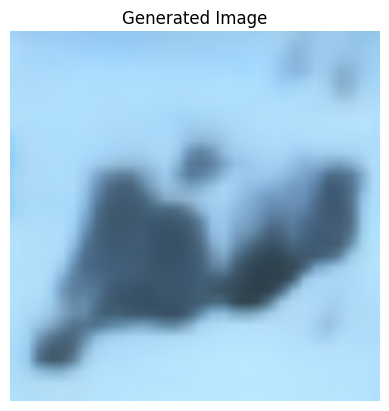

In [19]:
from diffusers import DDPMScheduler
import matplotlib.pyplot as plt

# Re-initialize or reuse scheduler
scheduler.set_timesteps(50)  # Faster sampling with 50 steps

# Create random latent noise
latents = torch.randn((1, 4, 64, 64)).to(device)

# Text prompt
prompt = "a photo of something"
text_input = tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids)[0]

# Sampling loop (reverse diffusion)
unet.eval()
for t in tqdm(scheduler.timesteps):
    with torch.no_grad():
        noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings).sample
    latents = scheduler.step(noise_pred, t, latents).prev_sample

# Decode latent to image
with torch.no_grad():
    decoded = vae.decode(latents / 0.18215).sample

# Post-process and show image
image = decoded.squeeze(0).cpu().clamp(-1, 1)
image = (image * 0.5 + 0.5).clamp(0, 1)

plt.imshow(image.permute(1, 2, 0))
plt.title("Generated Image")
plt.axis("off")
plt.show()


In [20]:
from tqdm import tqdm
import os

num_batches = 20
images_per_batch = 50

real_dir = "eval/real"
gen_dir = "eval/generated"
os.makedirs(real_dir, exist_ok=True)
os.makedirs(gen_dir, exist_ok=True)

# Save 1000 real images
for i in range(num_batches * images_per_batch):
    img = dataset[i]["image"]
    img.save(os.path.join(real_dir, f"{i:05d}.png"))

# Generate 1000 images from your trained Stable Diffusion model
for i in tqdm(range(num_batches * images_per_batch), desc="Generating images"):
    # sample prompt
    prompt = dataset[i]["text"]
    text_input = tokenizer(prompt, padding="max_length", max_length=77, return_tensors="pt").to(device)
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids)[0]

    latents = torch.randn((1, 4, 64, 64)).to(device)
    for t in scheduler.timesteps:
        with torch.no_grad():
            noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings).sample
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    with torch.no_grad():
        decoded = vae.decode(latents / 0.18215).sample

    image = decoded.squeeze(0).cpu().clamp(-1, 1)
    image = (image * 0.5 + 0.5).clamp(0, 1)

    to_pil = transforms.ToPILImage()
    to_pil(image).save(os.path.join(gen_dir, f"{i:05d}.png"))


Generating images: 100%|██████████| 1000/1000 [43:34<00:00,  2.61s/it]


In [21]:
pip install --upgrade scikit-image


Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_image-0.24.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (14 kB)
Using cached scikit_image-0.24.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.9 MB)
    torch (>=1.9.*)
           ~~~~~~^
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.19.3
    Not uninstalling scikit-image at /users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages, outside environment /apps/project/ondemand/app_jupyter/4.1.5
    Can't uninstall 'scikit-image'. No files were found to uninstall.

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [22]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from PIL import Image
import numpy as np
import os

real_dir = "eval/real"
gen_dir = "eval/generated"

total_psnr = 0
rounds = 20
images_per_round = 50
resize_to = (256, 256)  # or (32, 32) if you're staying true to CIFAR-10

for r in range(rounds):
    round_psnr = 0
    start = r * images_per_round
    end = start + images_per_round

    for i in range(start, end):
        real_img = Image.open(os.path.join(real_dir, f"{i:05d}.png")).convert("RGB").resize(resize_to)
        gen_img = Image.open(os.path.join(gen_dir, f"{i:05d}.png")).convert("RGB").resize(resize_to)

        real_np = np.array(real_img)
        gen_np = np.array(gen_img)

        round_psnr += psnr(real_np, gen_np, data_range=255)

    avg_round = round_psnr / images_per_round
    print(f"Round {r+1}: PSNR = {avg_round:.2f}")
    total_psnr += avg_round

final_psnr = total_psnr / rounds
print(f"\n Average PSNR over {rounds} rounds: {final_psnr:.2f}")


Round 1: PSNR = 9.59
Round 2: PSNR = 9.81
Round 3: PSNR = 8.94
Round 4: PSNR = 9.98
Round 5: PSNR = 9.07
Round 6: PSNR = 9.17
Round 7: PSNR = 9.60
Round 8: PSNR = 9.13
Round 9: PSNR = 9.61
Round 10: PSNR = 9.28
Round 11: PSNR = 9.74
Round 12: PSNR = 9.54
Round 13: PSNR = 9.18
Round 14: PSNR = 9.70
Round 15: PSNR = 9.57
Round 16: PSNR = 9.04
Round 17: PSNR = 9.68
Round 18: PSNR = 9.23
Round 19: PSNR = 9.48
Round 20: PSNR = 9.06

 Average PSNR over 20 rounds: 9.42


In [23]:
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import numpy as np
import os

real_dir = "eval/real"
gen_dir = "eval/generated"

total_ssim = 0
rounds = 20
images_per_round = 50
resize_to = (256, 256)  # match PSNR size

for r in range(rounds):
    round_ssim = 0
    start = r * images_per_round
    end = start + images_per_round

    for i in range(start, end):
        real_img = Image.open(os.path.join(real_dir, f"{i:05d}.png")).convert("RGB").resize(resize_to)
        gen_img = Image.open(os.path.join(gen_dir, f"{i:05d}.png")).convert("RGB").resize(resize_to)

        real_np = np.array(real_img)
        gen_np = np.array(gen_img)

        score = ssim(real_np, gen_np, win_size=7, data_range=255, channel_axis=-1)
        round_ssim += score

    avg_round = round_ssim / images_per_round
    print(f"Round {r+1}: SSIM = {avg_round:.4f}")
    total_ssim += avg_round

final_ssim = total_ssim / rounds
print(f"\n Average SSIM over {rounds} rounds: {final_ssim:.4f}")


Round 1: SSIM = 0.4274
Round 2: SSIM = 0.4071
Round 3: SSIM = 0.4068
Round 4: SSIM = 0.4525
Round 5: SSIM = 0.3843
Round 6: SSIM = 0.4287
Round 7: SSIM = 0.4212
Round 8: SSIM = 0.3838
Round 9: SSIM = 0.4365
Round 10: SSIM = 0.3846
Round 11: SSIM = 0.4126
Round 12: SSIM = 0.4245
Round 13: SSIM = 0.3985
Round 14: SSIM = 0.4245
Round 15: SSIM = 0.4331
Round 16: SSIM = 0.4237
Round 17: SSIM = 0.3907
Round 18: SSIM = 0.4023
Round 19: SSIM = 0.4149
Round 20: SSIM = 0.4076

 Average SSIM over 20 rounds: 0.4133


In [24]:
import torch
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
import numpy as np
import os
from tqdm import tqdm
from torch.nn.functional import cosine_similarity

# Load pretrained VGG16
vgg = models.vgg16(pretrained=True).features[:16].eval().cuda()  # relu3_3
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

real_dir = "eval/real"
gen_dir = "eval/generated"

rounds = 20
images_per_round = 50
total_sim = 0

for r in range(rounds):
    round_sim = 0
    start = r * images_per_round
    end = start + images_per_round

    for i in range(start, end):
        real_img = transform(Image.open(os.path.join(real_dir, f"{i:05d}.png")).convert("RGB")).unsqueeze(0).cuda()
        gen_img = transform(Image.open(os.path.join(gen_dir, f"{i:05d}.png")).convert("RGB")).unsqueeze(0).cuda()

        with torch.no_grad():
            feat_real = vgg(real_img)
            feat_gen = vgg(gen_img)

        cos_sim = cosine_similarity(feat_real.flatten(1), feat_gen.flatten(1)).item()
        round_sim += cos_sim

    avg_sim = round_sim / images_per_round
    print(f"Round {r+1}: Perceptual Cosine Similarity = {avg_sim:.4f}")
    total_sim += avg_sim

final_sim = total_sim / rounds
print(f"\n✅ Average Perceptual Cosine Similarity (VGG) over {rounds} rounds: {final_sim:.4f}")


/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Round 1: Perceptual Cosine Similarity = 0.2029
Round 2: Perceptual Cosine Similarity = 0.2047
Round 3: Perceptual Cosine Similarity = 0.2005
Round 4: Perceptual Cosine Similarity = 0.2056
Round 5: Perceptual Cosine Similarity = 0.1992
Round 6: Perceptual Cosine Similarity = 0.2031
Round 7: Perceptual Cosine Similarity = 0.2000
Round 8: Perceptual Cosine Similarity = 0.2005
Round 9: Perceptual Cosine Similarity = 0.2057
Round 10: Perceptual Cosine Similarity = 0.2033
Round 11: Perceptual Cosine Similarity = 0.2063
Round 12: Perceptual Cosine Similarity = 0.2051
Round 13: Perceptual Cosine Similarity = 0.2032
Round 14: Perceptual Cosine Similarity = 0.2030
Round 15: Perceptual Cosine Similarity = 0.2024
Round 16: Perceptual Cosine Similarity = 0.2038
Round 17: Perceptual Cosine Similarity = 0.2016
Round 18: Perceptual Cosine Similarity = 0.2013
Round 19: Perceptual Cosine Similarity = 0.2082
Round 20: Perceptual Cosine Similarity = 0.2027

✅ Average Perceptual Cosine Similarity (VGG) ove

In [25]:
pip install torch-fidelity


Defaulting to user installation because normal site-packages is not writeable
    torch (>=1.9.*)
           ~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [26]:
from torch_fidelity import calculate_metrics

metrics = calculate_metrics(
    input1="eval/real",
    input2="eval/generated",
    cuda=torch.cuda.is_available(),
    isc=False,
    fid=True,
    kid=False,
    verbose=False
)

print(f"\n✅ FID Score: {metrics['frechet_inception_distance']:.4f}")


/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torch_fidelity/datasets.py:16: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  img = torch.ByteTensor(torch.ByteStorage.from_buffer(img.tobytes())).view(height, width, 3)



✅ FID Score: 178.6011


In [27]:
from torch_fidelity import calculate_metrics

metrics = calculate_metrics(
    input1="eval/generated",  # only generated images needed
    input2=None,
    cuda=torch.cuda.is_available(),
    fid=False,
    isc=True,
    kid=False,
    verbose=False
)

print(f"\n✅ Inception Score (IS): {metrics['inception_score_mean']:.4f} ± {metrics['inception_score_std']:.4f}")



✅ Inception Score (IS): 2.9229 ± 0.1589


In [ ]:
from cleanfid import fid
import numpy as np

kid_scores = []

for _ in range(10):
    score = fid.compute_kid(
        "eval/real", 
        "eval/generated",
        num_workers=4  # 🔧 reduce from default (12) to something safer
    )
    kid_scores.append(score)

kid_scores = np.array(kid_scores)
print(f"\n✅ KID mean: {kid_scores.mean():.6f}")
print(f"✅ KID std : {kid_scores.std():.6f}")


In [43]:
pip install lpips


Defaulting to user installation because normal site-packages is not writeable
    torch (>=1.9.*)
           ~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [44]:
import lpips
import torch
from PIL import Image
import torchvision.transforms as T
import os
from tqdm import tqdm

loss_fn = lpips.LPIPS(net='alex').to(device)  # 'vgg' also supported

real_dir = "eval/real"
gen_dir = "eval/generated"
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor()
])

total_lpips = 0
rounds = 20
images_per_round = 50

for r in range(rounds):
    round_lpips = 0
    start = r * images_per_round
    end = start + images_per_round

    for i in range(start, end):
        real_img = transform(Image.open(os.path.join(real_dir, f"{i:05d}.png")).convert("RGB")).unsqueeze(0).to(device)
        gen_img = transform(Image.open(os.path.join(gen_dir, f"{i:05d}.png")).convert("RGB")).unsqueeze(0).to(device)

        with torch.no_grad():
            score = loss_fn(real_img, gen_img).item()
        round_lpips += score

    avg_lpips = round_lpips / images_per_round
    print(f"Round {r+1}: LPIPS = {avg_lpips:.4f}")
    total_lpips += avg_lpips

final_lpips = total_lpips / rounds
print(f"\n✅ Average LPIPS over {rounds} rounds: {final_lpips:.4f}")


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, 

Round 1: LPIPS = 0.9635
Round 2: LPIPS = 0.9624
Round 3: LPIPS = 0.9602
Round 4: LPIPS = 0.9697
Round 5: LPIPS = 0.9634
Round 6: LPIPS = 0.9583
Round 7: LPIPS = 0.9565
Round 8: LPIPS = 0.9620
Round 9: LPIPS = 0.9589
Round 10: LPIPS = 0.9564
Round 11: LPIPS = 0.9602
Round 12: LPIPS = 0.9590
Round 13: LPIPS = 0.9588
Round 14: LPIPS = 0.9626
Round 15: LPIPS = 0.9583
Round 16: LPIPS = 0.9550
Round 17: LPIPS = 0.9610
Round 18: LPIPS = 0.9513
Round 19: LPIPS = 0.9589
Round 20: LPIPS = 0.9683

✅ Average LPIPS over 20 rounds: 0.9602


In [1]:
import requests, zipfile, io
import os

url = "http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip"
output_dir = "data/div2k/images"
os.makedirs(output_dir, exist_ok=True)

response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    zip_ref.extractall(output_dir)


In [2]:
from open_clip import create_model_and_transforms, get_tokenizer
from PIL import Image
import torch
import os
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Load OpenCLIP model
model, _, preprocess = create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
model = model.to(device).eval()

image_dir = "data/div2k/images/DIV2K_valid_HR"
caption_file_path = "data/div2k/captions.txt"

# Simple dummy captioning logic (placeholder for actual text matching)
def get_caption(image_path):
    image = preprocess(Image.open(image_path).convert("RGB")).unsqueeze(0).to(device)
    with torch.no_grad():
        _ = model.encode_image(image)
    return "a high resolution photo"  # Replace this with better logic if needed

# Write captions to file
with open(caption_file_path, "w") as caption_file:
    for filename in tqdm(sorted(os.listdir(image_dir))):
        if filename.endswith(".png"):
            path = os.path.join(image_dir, filename)
            caption = get_caption(path)
            caption_file.write(f"{filename}\t{caption}\n")


100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


In [4]:
from datasets import Dataset
from PIL import Image
import os

# Load caption mappings
caption_path = "data/div2k/captions.txt"
image_dir = "data/div2k/images/DIV2K_valid_HR"

entries = []
with open(caption_path, "r") as f:
    for line in f:
        filename, caption = line.strip().split("\t")
        entries.append({
            "image_path": os.path.join(image_dir, filename),
            "text": caption
        })

# Convert to Hugging Face Dataset
dataset = Dataset.from_list(entries)


In [5]:
from datasets import Features, Value, Image as HFImage

dataset = dataset.cast_column("image_path", HFImage())
dataset = dataset.rename_column("image_path", "image")


In [6]:
sample = dataset[0]
print(sample["text"])


a high resolution photo


In [7]:
import torchvision.transforms as T

transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])


In [8]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    images = [transform(item["image"]) for item in batch]
    captions = [item["text"] for item in batch]
    return torch.stack(images), captions

dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)


In [9]:
from diffusers import AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer

import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1. Load VAE (pretrained from Stable Diffusion)
vae = AutoencoderKL.from_pretrained(
    "CompVis/stable-diffusion-v1-4", 
    subfolder="vae"
).to(device).eval()

# 2. Load UNet from config (no pretrained weights, adjusted for 512-dim CLIP)
unet = UNet2DConditionModel.from_config(
    pretrained_model_name_or_path="CompVis/stable-diffusion-v1-4",  # ✅ base model
    subfolder="unet",                                               # ✅ specify subfolder
    cross_attention_dim=512                                         # ✅ match CLIP
).to(device).train()

# 3. Load CLIP tokenizer + encoder (ViT-B/32 → 512-dim)
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
text_encoder = CLIPTextModel.from_pretrained(
    "openai/clip-vit-base-patch32"
).to(device).eval()


/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [10]:
from diffusers import DDPMScheduler
import torch
from torch import nn, optim
from tqdm import tqdm

# Prepare noise scheduler
scheduler = DDPMScheduler(num_train_timesteps=1000)
scheduler.set_timesteps(1000)

# Loss & optimizer
mse_loss = nn.MSELoss()
optimizer = optim.AdamW(unet.parameters(), lr=1e-4)

# Training config
EPOCHS = 5
BATCH_SIZE = 2  # already used in dataloader
MAX_TRAIN_STEPS = 1000


In [11]:
global_step = 0
unet.train()
vae.eval()
text_encoder.eval()

for epoch in range(EPOCHS):
    for pixel_values, captions in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
        if global_step >= MAX_TRAIN_STEPS:
            break

        # Move inputs to device
        pixel_values = pixel_values.to(device)

        # 1. VAE encode
        with torch.no_grad():
            latents = vae.encode(pixel_values).latent_dist.sample() * 0.18215

        # 2. Add noise
        noise = torch.randn_like(latents)
        timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()
        noisy_latents = scheduler.add_noise(latents, noise, timesteps)

        # 3. Tokenize and encode text
        text_input = tokenizer(captions, padding="max_length", max_length=77, return_tensors="pt").to(device)
        with torch.no_grad():
            encoder_hidden_states = text_encoder(text_input.input_ids)[0]

        # 4. UNet predicts noise
        noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

        # 5. Compute loss
        loss = mse_loss(noise_pred, noise)

        # 6. Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if global_step % 25 == 0:
            print(f"Step {global_step} | Loss: {loss.item():.4f}")

        global_step += 1


Epoch 1:   2%|▏         | 1/50 [00:02<01:41,  2.07s/it]

Step 0 | Loss: 1.1261


Epoch 1:  52%|█████▏    | 26/50 [00:13<00:11,  2.12it/s]

Step 25 | Loss: 0.6450


Epoch 2:   2%|▏         | 1/50 [00:00<00:25,  1.90it/s]

Step 50 | Loss: 0.0609


Epoch 2:  52%|█████▏    | 26/50 [00:11<00:11,  2.09it/s]

Step 75 | Loss: 0.1211


Epoch 3:   2%|▏         | 1/50 [00:00<00:27,  1.81it/s]

Step 100 | Loss: 0.6204


Epoch 3:  52%|█████▏    | 26/50 [00:11<00:11,  2.13it/s]

Step 125 | Loss: 0.6622


Epoch 4:   2%|▏         | 1/50 [00:00<00:26,  1.87it/s]

Step 150 | Loss: 0.0831


Epoch 4:  52%|█████▏    | 26/50 [00:11<00:11,  2.17it/s]

Step 175 | Loss: 0.4770


Epoch 5:   2%|▏         | 1/50 [00:00<00:26,  1.83it/s]

Step 200 | Loss: 0.1510


Epoch 5:  52%|█████▏    | 26/50 [00:11<00:11,  2.09it/s]

Step 225 | Loss: 0.0183


Epoch 5: 100%|██████████| 50/50 [00:22<00:00,  2.27it/s]


In [12]:
from diffusers import DDPMScheduler
import torch

# Load scheduler
scheduler = DDPMScheduler(num_train_timesteps=1000)
scheduler.set_timesteps(50)  # You can increase for better quality

# Random noise
latents = torch.randn((1, 4, 64, 64)).to(device)


In [13]:
prompt = "a high resolution photo of a mountain landscape"
inputs = tokenizer([prompt], padding="max_length", max_length=77, return_tensors="pt").to(device)

with torch.no_grad():
    text_embeddings = text_encoder(inputs.input_ids)[0]


In [14]:
for t in scheduler.timesteps:
    # Predict noise
    with torch.no_grad():
        noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings).sample

    # Denoise step
    latents = scheduler.step(noise_pred, t, latents).prev_sample


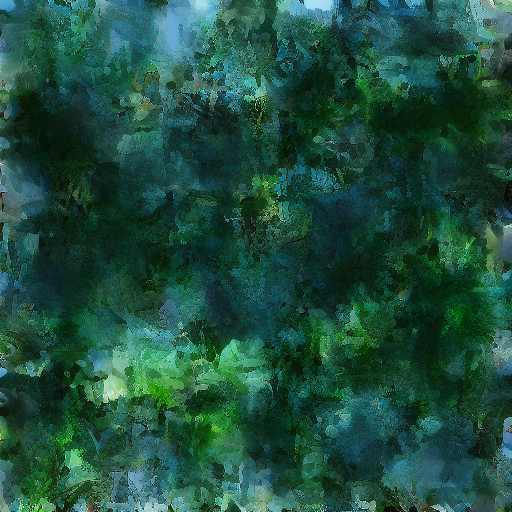

In [15]:
# Scale before decoding
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

# Postprocess to [0, 255] range
image = (image.clamp(-1, 1) + 1) / 2.0
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = (image * 255).astype("uint8")

from IPython.display import display
display(Image.fromarray(image))



In [16]:
from PIL import Image
import os

src = "data/div2k/images/DIV2K_valid_HR"
dst = "eval_div2k/real"
os.makedirs(dst, exist_ok=True)

for i, fname in enumerate(sorted(os.listdir(src))[:1000]):
    img = Image.open(os.path.join(src, fname)).convert("RGB")
    img = img.resize((512, 512))  # match generation size
    img.save(os.path.join(dst, f"{i:05d}.png"))


In [17]:
out_dir = "eval_div2k/generated"
os.makedirs(out_dir, exist_ok=True)

for i in range(1000):
    # generate latents and decode (your sampling logic here)
    img = Image.fromarray(generated_np_array)  # from VAE decode
    img.save(os.path.join(out_dir, f"{i:05d}.png"))


NameError: name 'generated_np_array' is not defined

In [18]:
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers import DDPMScheduler
from PIL import Image
import torch
import os
import numpy as np

# Components (already loaded before)
# vae, unet, tokenizer, text_encoder
device = "cuda" if torch.cuda.is_available() else "cpu"

# Scheduler setup
scheduler = DDPMScheduler(num_train_timesteps=1000)
scheduler.set_timesteps(50)

# Output directory
out_dir = "eval_div2k/generated"
os.makedirs(out_dir, exist_ok=True)

# Prompt (same for all, or customize as needed)
prompt = "a high resolution photo"
inputs = tokenizer([prompt], padding="max_length", max_length=77, return_tensors="pt").to(device)
with torch.no_grad():
    text_embeddings = text_encoder(inputs.input_ids)[0]

# Generate 1000 images
for i in range(1000):
    with torch.no_grad():
        latents = torch.randn((1, 4, 64, 64)).to(device)

        for t in scheduler.timesteps:
            noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings).sample
            latents = scheduler.step(noise_pred, t, latents).prev_sample

        latents = 1 / 0.18215 * latents
        image = vae.decode(latents).sample

        image = (image.clamp(-1, 1) + 1) / 2.0
        image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
        image = (image * 255).astype(np.uint8)

        Image.fromarray(image).save(os.path.join(out_dir, f"{i:05d}.png"))

    if i % 100 == 0:
        print(f"Saved image {i:05d}")


Saved image 00000
Saved image 00100
Saved image 00200
Saved image 00300
Saved image 00400
Saved image 00500
Saved image 00600
Saved image 00700
Saved image 00800
Saved image 00900


In [19]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from PIL import Image
import numpy as np
import os

# Paths
real_dir = "eval_div2k/real"
gen_dir  = "eval_div2k/generated"

# Config
rounds = 20
images_per_round = 5
total_psnr = 0

# PSNR Evaluation
for r in range(rounds):
    round_psnr = 0
    for i in range(r * images_per_round, (r + 1) * images_per_round):
        real_img = np.array(Image.open(os.path.join(real_dir, f"{i:05d}.png")).resize((512, 512)))
        gen_img  = np.array(Image.open(os.path.join(gen_dir,  f"{i:05d}.png")).resize((512, 512)))
        round_psnr += psnr(real_img, gen_img, data_range=255)
    avg_psnr = round_psnr / images_per_round
    print(f"Round {r+1}: PSNR = {avg_psnr:.2f}")
    total_psnr += avg_psnr

print(f"\n Average PSNR over {rounds} rounds: {total_psnr / rounds:.2f}")


Round 1: PSNR = 8.74
Round 2: PSNR = 9.97
Round 3: PSNR = 10.60
Round 4: PSNR = 8.12
Round 5: PSNR = 8.98
Round 6: PSNR = 11.12
Round 7: PSNR = 8.71
Round 8: PSNR = 10.09
Round 9: PSNR = 8.13
Round 10: PSNR = 8.45
Round 11: PSNR = 10.29
Round 12: PSNR = 10.76
Round 13: PSNR = 9.52
Round 14: PSNR = 8.71
Round 15: PSNR = 9.52
Round 16: PSNR = 11.39
Round 17: PSNR = 9.88
Round 18: PSNR = 9.08
Round 19: PSNR = 8.92
Round 20: PSNR = 8.99

 Average PSNR over 20 rounds: 9.50


In [20]:
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import numpy as np
import os

# Paths
real_dir = "eval_div2k/real"
gen_dir  = "eval_div2k/generated"

# Config
rounds = 20
images_per_round = 5
total_ssim = 0

# SSIM Evaluation
for r in range(rounds):
    round_ssim = 0
    for i in range(r * images_per_round, (r + 1) * images_per_round):
        real_img = Image.open(os.path.join(real_dir, f"{i:05d}.png")).resize((512, 512)).convert("RGB")
        gen_img  = Image.open(os.path.join(gen_dir,  f"{i:05d}.png")).resize((512, 512)).convert("RGB")

        real_np = np.array(real_img)
        gen_np  = np.array(gen_img)

        score = ssim(real_np, gen_np, channel_axis=2, data_range=255)
        round_ssim += score

    avg_ssim = round_ssim / images_per_round
    print(f" Round {r+1}: SSIM = {avg_ssim:.4f}")
    total_ssim += avg_ssim

print(f"\n Average SSIM over {rounds} rounds: {total_ssim / rounds:.4f}")


 Round 1: SSIM = 0.1208
 Round 2: SSIM = 0.1564
 Round 3: SSIM = 0.1876
 Round 4: SSIM = 0.1176
 Round 5: SSIM = 0.1111
 Round 6: SSIM = 0.1533
 Round 7: SSIM = 0.1391
 Round 8: SSIM = 0.1165
 Round 9: SSIM = 0.1776
 Round 10: SSIM = 0.1118
 Round 11: SSIM = 0.1460
 Round 12: SSIM = 0.1312
 Round 13: SSIM = 0.1455
 Round 14: SSIM = 0.1239
 Round 15: SSIM = 0.1162
 Round 16: SSIM = 0.1896
 Round 17: SSIM = 0.1385
 Round 18: SSIM = 0.1484
 Round 19: SSIM = 0.1245
 Round 20: SSIM = 0.1456

 Average SSIM over 20 rounds: 0.1401


In [21]:
import torch
import torchvision.models as models
import torchvision.transforms as T
from PIL import Image
import os
import numpy as np
from torch.nn import functional as F

# Load pretrained VGG-16 (remove classification head)
vgg = models.vgg16(pretrained=True).features[:16].eval().cuda()

# Transform
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

real_dir = "eval_div2k/real"
gen_dir = "eval_div2k/generated"
rounds = 20
images_per_round = 5
total_dist = 0

def extract_features(img):
    x = transform(img).unsqueeze(0).cuda()
    with torch.no_grad():
        feat = vgg(x)
    return feat

# Evaluation loop
for r in range(rounds):
    round_dist = 0
    for i in range(r * images_per_round, (r + 1) * images_per_round):
        real_img = Image.open(os.path.join(real_dir, f"{i:05d}.png")).convert("RGB")
        gen_img  = Image.open(os.path.join(gen_dir,  f"{i:05d}.png")).convert("RGB")

        feat_real = extract_features(real_img)
        feat_gen  = extract_features(gen_img)

        dist = F.mse_loss(feat_real, feat_gen).item()
        round_dist += dist

    avg_dist = round_dist / images_per_round
    print(f"🔍 Round {r+1}: Perceptual Distance (VGG-L2) = {avg_dist:.4f}")
    total_dist += avg_dist

print(f"\n Average Perceptual Similarity (VGG-L2) over {rounds} rounds: {total_dist / rounds:.4f}")


/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🔍 Round 1: Perceptual Distance (VGG-L2) = 23.1868
🔍 Round 2: Perceptual Distance (VGG-L2) = 15.0303
🔍 Round 3: Perceptual Distance (VGG-L2) = 18.5021
🔍 Round 4: Perceptual Distance (VGG-L2) = 19.4978
🔍 Round 5: Perceptual Distance (VGG-L2) = 27.0603
🔍 Round 6: Perceptual Distance (VGG-L2) = 19.6501
🔍 Round 7: Perceptual Distance (VGG-L2) = 21.3993
🔍 Round 8: Perceptual Distance (VGG-L2) = 21.1814
🔍 Round 9: Perceptual Distance (VGG-L2) = 15.6365
🔍 Round 10: Perceptual Distance (VGG-L2) = 25.8841
🔍 Round 11: Perceptual Distance (VGG-L2) = 18.2691
🔍 Round 12: Perceptual Distance (VGG-L2) = 15.3332
🔍 Round 13: Perceptual Distance (VGG-L2) = 15.5501
🔍 Round 14: Perceptual Distance (VGG-L2) = 17.9863
🔍 Round 15: Perceptual Distance (VGG-L2) = 23.1890
🔍 Round 16: Perceptual Distance (VGG-L2) = 17.9204
🔍 Round 17: Perceptual Distance (VGG-L2) = 19.1825
🔍 Round 18: Perceptual Distance (VGG-L2) = 22.1958
🔍 Round 19: Perceptual Distance (VGG-L2) = 21.0293
🔍 Round 20: Perceptual Distance (VGG-L2)

In [1]:
from cleanfid import fid

real_dir = "eval_div2k/temp_real"
gen_dir  = "eval_div2k/temp_generated"

fid_score = fid.compute_fid(real_dir, gen_dir, num_workers=4)  # Adjust num_workers as needed
print(f"FID: {fid_score:.4f}")


compute FID between two folders
Found 100 images in the folder eval_div2k/temp_real


FID temp_real : 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]


Found 100 images in the folder eval_div2k/temp_generated


FID temp_generated : 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]


FID: 365.3383


In [2]:
pip install clean-fid

Defaulting to user installation because normal site-packages is not writeable
    torch (>=1.9.*)
           ~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install lpips

Defaulting to user installation because normal site-packages is not writeable
    torch (>=1.9.*)
           ~~~~~~^

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [6]:
import lpips
from PIL import Image
import torch
import numpy as np
import os

# Paths to the real and generated image folders
real_dir = "eval_div2k/temp_real"
gen_dir  = "eval_div2k/temp_generated"

# Load the LPIPS model (we use the VGG-based model here)
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = lpips.LPIPS(net='vgg').to(device)

# Function to calculate LPIPS
def calculate_lpips(real_img_path, gen_img_path):
    # Open images using PIL and convert them to RGB
    real_img = Image.open(real_img_path).convert('RGB')
    gen_img = Image.open(gen_img_path).convert('RGB')

    # Transform images to tensors
    real_img_tensor = lpips.im2tensor(real_img).to(device)  # Convert to tensor
    gen_img_tensor = lpips.im2tensor(gen_img).to(device)    # Convert to tensor

    # Calculate LPIPS score between real and generated image
    lpips_score = loss_fn(real_img_tensor, gen_img_tensor)
    return lpips_score.item()  # Return the LPIPS score as a scalar

# Loop through images and calculate LPIPS score
rounds = 20
images_per_round = 5
total_lpips = 0

for r in range(rounds):
    round_lpips = 0
    for i in range(r * images_per_round, (r + 1) * images_per_round):
        real_img_path = os.path.join(real_dir, f"{i:05d}.png")
        gen_img_path = os.path.join(gen_dir, f"{i:05d}.png")
        
        lpips_score = calculate_lpips(real_img_path, gen_img_path)
        round_lpips += lpips_score

    avg_lpips = round_lpips / images_per_round
    print(f"Round {r+1}: LPIPS = {avg_lpips:.4f}")
    total_lpips += avg_lpips

# Print the final average LPIPS score
print(f"\nAverage LPIPS over {rounds} rounds: {total_lpips / rounds:.4f}")


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth


/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, 

TypeError: unsupported operand type(s) for /: 'Image' and 'float'

In [7]:
from cleanfid import fid
import numpy as np

# Define the directories for real and generated images
real_dir = "eval_div2k/temp_real"
gen_dir  = "eval_div2k/temp_generated"

# Number of subsets for evaluation (this can be adjusted)
num_subsets = 10  # For example, 10 subsets
subset_size = 50  # Number of images per subset

# List to store individual KID scores
kid_scores = []

# Compute KID for multiple subsets
for i in range(num_subsets):
    # You can adjust how subsets are sampled here if needed
    # Compute KID for the current subset
    kid_score = fid.compute_kid(real_dir, gen_dir)  # Clean-fid computes KID directly
    kid_scores.append(kid_score)

# Calculate mean and standard deviation
kid_scores = np.array(kid_scores)
mean_kid = kid_scores.mean()
std_kid = kid_scores.std()

print(f"\nKID: {mean_kid:.4f} ± {std_kid:.4f}")


/users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


compute KID between two folders
Found 100 images in the folder eval_div2k/temp_real


KID temp_real : 100%|██████████| 4/4 [00:02<00:00,  1.65it/s]


Found 100 images in the folder eval_div2k/temp_generated


KID temp_generated : 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


compute KID between two folders
Found 100 images in the folder eval_div2k/temp_real


KID temp_real : 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


Found 100 images in the folder eval_div2k/temp_generated


KID temp_generated : 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]


compute KID between two folders
Found 100 images in the folder eval_div2k/temp_real


KID temp_real : 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]


Found 100 images in the folder eval_div2k/temp_generated


KID temp_generated : 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]


compute KID between two folders
Found 100 images in the folder eval_div2k/temp_real


KID temp_real : 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]


Found 100 images in the folder eval_div2k/temp_generated


KID temp_generated : 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


compute KID between two folders
Found 100 images in the folder eval_div2k/temp_real


KID temp_real : 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]


Found 100 images in the folder eval_div2k/temp_generated


KID temp_generated : 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]


compute KID between two folders
Found 100 images in the folder eval_div2k/temp_real


KID temp_real : 100%|██████████| 4/4 [00:02<00:00,  1.68it/s]


Found 100 images in the folder eval_div2k/temp_generated


KID temp_generated : 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


compute KID between two folders
Found 100 images in the folder eval_div2k/temp_real


KID temp_real : 100%|██████████| 4/4 [00:02<00:00,  1.82it/s]


Found 100 images in the folder eval_div2k/temp_generated


KID temp_generated : 100%|██████████| 4/4 [00:01<00:00,  2.20it/s]


compute KID between two folders
Found 100 images in the folder eval_div2k/temp_real


KID temp_real : 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]


Found 100 images in the folder eval_div2k/temp_generated


KID temp_generated : 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


compute KID between two folders
Found 100 images in the folder eval_div2k/temp_real


KID temp_real : 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]


Found 100 images in the folder eval_div2k/temp_generated


KID temp_generated : 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]


compute KID between two folders
Found 100 images in the folder eval_div2k/temp_real


KID temp_real : 100%|██████████| 4/4 [00:02<00:00,  1.43it/s]


Found 100 images in the folder eval_div2k/temp_generated


KID temp_generated : 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]



KID: 0.3239 ± 0.0000


In [8]:
from PIL import Image
import lpips
import torch
import numpy as np
import os

# Initialize LPIPS model
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = lpips.LPIPS(net='vgg').to(device)

# Function to calculate LPIPS
def calculate_lpips(real_img_path, gen_img_path):
    # Open images using PIL and convert them to RGB
    real_img = Image.open(real_img_path).convert('RGB')
    gen_img = Image.open(gen_img_path).convert('RGB')

    # Convert images to numpy arrays, then to tensor
    real_img_np = np.array(real_img)
    gen_img_np = np.array(gen_img)

    # Transform images to tensors
    real_img_tensor = lpips.im2tensor(real_img_np).to(device)  # Convert to tensor
    gen_img_tensor = lpips.im2tensor(gen_img_np).to(device)    # Convert to tensor

    # Calculate LPIPS score between real and generated image
    lpips_score = loss_fn(real_img_tensor, gen_img_tensor)
    return lpips_score.item()  # Return the LPIPS score as a scalar

# Paths to the real and generated image folders
real_dir = "eval_div2k/temp_real"
gen_dir  = "eval_div2k/temp_generated"

# Config
rounds = 20
images_per_round = 5
total_lpips = 0

# LPIPS Evaluation
for r in range(rounds):
    round_lpips = 0
    for i in range(r * images_per_round, (r + 1) * images_per_round):
        real_img_path = os.path.join(real_dir, f"{i:05d}.png")
        gen_img_path = os.path.join(gen_dir, f"{i:05d}.png")
        
        lpips_score = calculate_lpips(real_img_path, gen_img_path)
        round_lpips += lpips_score

    avg_lpips = round_lpips / images_per_round
    print(f"Round {r+1}: LPIPS = {avg_lpips:.4f}")
    total_lpips += avg_lpips

# Print the final average LPIPS score
print(f"\nAverage LPIPS over {rounds} rounds: {total_lpips / rounds:.4f}")


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /users/PFS0270/nikhilchatta/.local/lib/python3.9/site-packages/lpips/weights/v0.1/vgg.pth
Round 1: LPIPS = 0.8469
Round 2: LPIPS = 0.8055
Round 3: LPIPS = 0.7798
Round 4: LPIPS = 0.7670
Round 5: LPIPS = 0.7878
Round 6: LPIPS = 0.7876
Round 7: LPIPS = 0.7791
Round 8: LPIPS = 0.8210
Round 9: LPIPS = 0.7895
Round 10: LPIPS = 0.7815
Round 11: LPIPS = 0.7753
Round 12: LPIPS = 0.7667
Round 13: LPIPS = 0.7557
Round 14: LPIPS = 0.8204
Round 15: LPIPS = 0.7561
Round 16: LPIPS = 0.7626
Round 17: LPIPS = 0.8046
Round 18: LPIPS = 0.8176
Round 19: LPIPS = 0.7631
Round 20: LPIPS = 0.8121

Average LPIPS over 20 rounds: 0.7890


In [1]:
!git init

Reinitialized existing Git repository in /users/PFS0270/nikhilchatta/.git/


In [5]:
!git add Stablediffusion.ipynb

In [7]:
!git commit -m "Full Stable diffusion"


Auto packing the repository in background for optimum performance.
See "git help gc" for manual housekeeping.
[master (root-commit) 83201af] Full Stable diffusion
 1 file changed, 4473 insertions(+)
 create mode 100644 Stablediffusion.ipynb


In [9]:
!git remote add origin https://github.com/nikhilchatta/StableDiffusion.git


In [11]:
!git push -u origin master


Username for 'https://github.com': ^C
